In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ADFTest
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [247]:
df = pd.read_csv("../data library/Soja_v1.csv", sep=";")
df = df.sort_values(by="Data")
df = df.reset_index(drop=True)

# df['seasonal_feature'] = df['Data'].apply(lambda x: seasonal_pattern(x))
# df['trend_feature'] = df['Data'].apply(lambda x: trend_pattern(x))

df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0


In [243]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [250]:
df["USD"] = df_usd["USD"]
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0,2.905457
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0,2.905985
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0,3.100419
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0,3.129148
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0,3.036777


In [3]:
X = ["País", "Último", "Abertura", "Máxima", "Mínima"]
Y = "Estadual"

In [130]:
df2 = df.copy()

df2['Data'] = pd.to_datetime(df2['Data'])

df2["Month"] = df2["Data"].dt.month
df2["Quarter"] = df2["Data"].dt.quarter
df2["Year"] = df2["Data"].dt.year

train_df = df2[:(int(len(df2)*0.8))].copy()
test_df = df2[(int(len(df2)*0.8)):].copy()

In [5]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year"]]
y_test = testing_data["Estadual"]

In [275]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

def xg_model(X_train, y_train, X_test):
    cv_split = TimeSeriesSplit(n_splits=2, test_size=len(X_test)-24)
    model = XGBRegressor(n_estimators=1000)
    parameters = {
        "max_depth": [3, 4, 6, 5, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "n_estimators": [100, 300, 500, 700, 900, 1000],
        "colsample_bytree": [0.3, 0.5, 0.7]
    }

    grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    xgb_model = XGBRegressor(**best_params)
    xgb_model.fit(X_train, y_train)

    predictions = xgb_model.predict(X_test)

    return predictions

In [7]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.metrics import r2_score

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  _, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

Variáveis

In [252]:
df2 = df.copy()

df2['Data'] = pd.to_datetime(df2['Data'])

end = df2.Data.iat[-1]
K = 24
 
date_generated = pd.date_range(end, periods=K, freq="MS")
expand_df = pd.DataFrame(date_generated, columns=["Data"])

df2 = pd.concat([df2, expand_df], ignore_index=True)

df2["Month"] = df2["Data"].dt.month
df2["Quarter"] = df2["Data"].dt.quarter
df2["Year"] = df2["Data"].dt.year

train_df = df2[:(int((len(df2)-K)*0.8))].copy()
test_df = df2[(int((len(df2)-K)*0.8)):].copy()

In [256]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year"]]
y_train = training_data["País"]

X_test = testing_data[["Month", "Quarter", "Year"]]
y_test = testing_data["País"]

In [166]:
pred = xg_model(X_train, y_train, X_test)

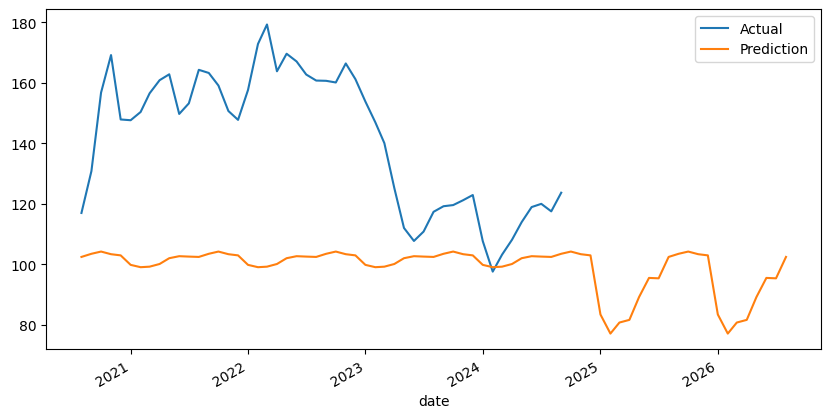

In [167]:
plot_predictions(testing_dates, y_test, pred)
df_test_pred = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": pred})

In [168]:
test_df["País"][49:] = df_test_pred["prediction"][49:]
test_df

C:\Users\hamatsu\AppData\Local\Temp\ipykernel_25720\3898385435.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_df["País"][49:] = df_test_pred["prediction"][49:]
C:\Users\hamatsu\AppData\Local\Temp\ipykernel_25720\3898385435.py:1: Se

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,Month,Quarter,Year
196,2020-08-01,Soja,117.0222,113.337500,0.0,95250.00000,89175.00000,96688.00000,86538.00000,8,3,2020
197,2020-09-01,Soja,130.8449,128.300400,0.0,1.02175,95062.00000,1.04650,94288.00000,9,3,2020
198,2020-10-01,Soja,156.7972,147.412100,0.0,1.05688,1.02338,1.09388,1.01300,10,4,2020
199,2020-11-01,Soja,169.1946,157.398200,0.0,1.16875,1.06025,1.19962,1.04162,11,4,2020
200,2020-12-01,Soja,147.9145,140.930100,0.0,1.31025,1.16962,1.32060,1.14262,12,4,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
265,2026-04-01,NaN,NaN,81.701180,NaN,NaN,NaN,NaN,NaN,4,2,2026
266,2026-05-01,NaN,NaN,89.228844,NaN,NaN,NaN,NaN,NaN,5,2,2026
267,2026-06-01,NaN,NaN,95.562027,NaN,NaN,NaN,NaN,NaN,6,2,2026
268,2026-07-01,NaN,NaN,95.429123,NaN,NaN,NaN,NaN,NaN,7,3,2026


In [169]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year", "País"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year", "País"]]
y_test = testing_data["Estadual"]

In [170]:
pred = xg_model(X_train, y_train, X_test)

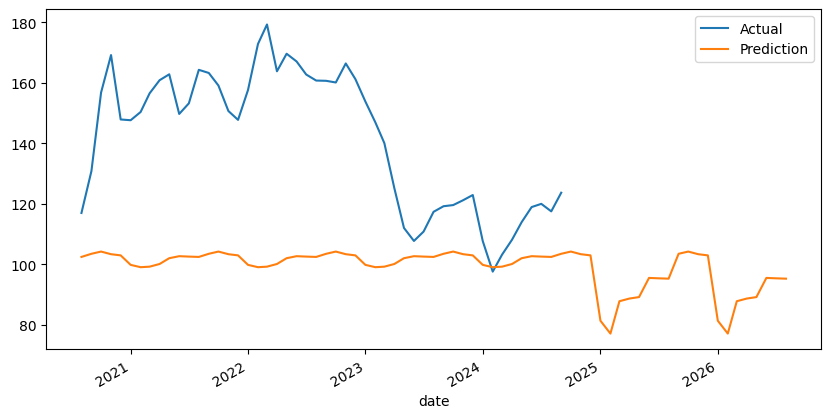

MAE: 39.714096402832034
RMSE: 45.68336725321778
MAPE: 0.2605969583916636
R-Squared: -3.0632253530750013


In [172]:
plot_predictions(testing_dates, y_test, pred)
evaluate_model(y_test[:50], pred[:50])

In [259]:
train_df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Month,Quarter,Year
0,2004-03-01,Soja,45.3777,50.0455,0.0,1.034,1.000,1.064,92600.0,2.905457,3,1,2004
1,2004-04-01,Soja,45.9456,48.7279,0.0,81400.000,1.036,1.063,81200.0,2.905985,4,2,2004
2,2004-05-01,Soja,44.8723,47.4930,0.0,89300.000,82800.000,94000.000,0.0,3.100419,5,2,2004
3,2004-06-01,Soja,38.5913,40.7781,0.0,59950.000,89200.000,1.035,59900.0,3.129148,6,2,2004
4,2004-07-01,Soja,34.0818,37.5474,0.0,62725.000,59100.000,71200.000,56500.0,3.036777,7,3,2004


In [277]:
training_data = train_df.copy()
testing_data = test_df.copy()

training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year", "USD"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year", "USD"]]
y_test = testing_data["Estadual"]

In [278]:
pred = xg_model(X_train, y_train, X_test)

C:\Users\hamatsu\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


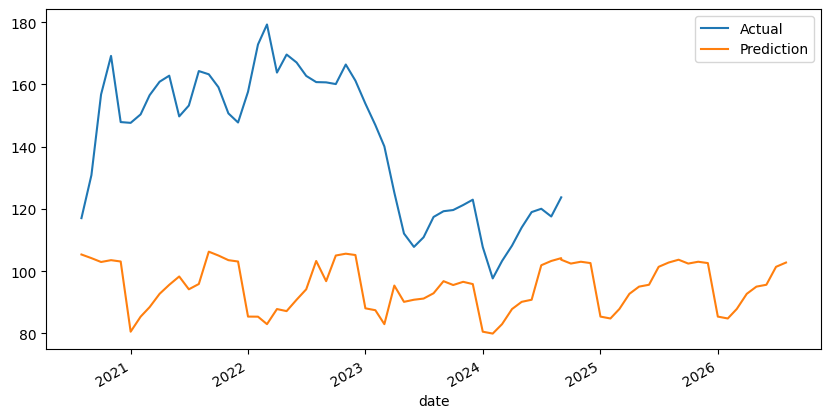

MAE: 47.152896585693355
RMSE: 52.31582003589342
MAPE: 0.3165172238902862
R-Squared: -4.328693842000145


In [280]:
plot_predictions(testing_dates, y_test, pred)
evaluate_model(y_test[:50], pred[:50])